In [26]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt # load plotting libraries
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from custom Python script
import regionmask


In [27]:
# Approximate the area of a spatial grid square from the latitudes and longitudes of the diagonal vertices
def area_latlon(lat1, lon1, lat2, lon2):
    # This function calculates the area (in km^2) of a spatial grid square, given the latitudes and longitudes of the two diagonal vertices of the grid square.
    # lat/lon is in angle; lat: [-90:90]; lon:[-180:180].
    # lat1/lon1 and lat2/lon2 are thus the diagonal vertices of the square grid.
    lat1 = lat1/180*np.pi
    lat2 = lat2/180*np.pi
    lon1 = lon1/180*np.pi
    lon2 = lon2/180*np.pi
    A = np.absolute(6371.009**2*(np.sin(lat2)-np.sin(lat1))*(lon2-lon1))
    return A


In [28]:
# input: a xarray dataarray or dataset with lon and lat
# output: [[lat1,lon1], [lat2,lon2]], smallest box covering dataset
def lat_lon_bounds(ds):
    minlat = math.floor(ds.lat.min())
    maxlat = math.ceil(ds.lat.max())
    minlon = math.floor(ds.lon.min())
    maxlon = math.ceil(ds.lon.max())
    mins = [minlat, minlon] 
    maxs = [maxlat, maxlon]
    
    for i in range(len(mins)):
        if mins[i]%5 != 0: mins[i] = mins[i] - mins[i]%5
    for i in range(len(maxs)):
        if maxs[i]%5 != 0: maxs[i] = maxs[i] + 5 - maxs[i]%5
    ans = [mins,maxs] # ends with 0 or 5, GEOS-Chem grids keep these grid points even    
    return ans


In [29]:
# regrid a xarray dataarray from finer resolution to coarser resolution (res)
# ds is the dataset, varnames are variables need to be regridded
def regrid_fine_to_coarse_sum(ds, varnames, res_lat, res_lon):
    # get outer bounds of input data, [[lat1,lon1], [lat2,lon2]] 
    bounds = lat_lon_bounds(ds)
    # target grid
    target = xr.DataArray(0, dims=('lat', 'lon'), 
                            coords={'lat': np.arange(bounds[0][0], bounds[1][0] + res_lat, res_lat), # larger than CHE domain
                                    'lon': np.arange(bounds[0][1], bounds[1][1] + res_lon, res_lon)}) # slightly smaller than TNO domain
    target = target.astype(dtype='float64')
    output = target.to_dataset(name = varnames[0])
    for ivar in varnames: output[ivar] = target.copy()
    # regridding
    for ivar in varnames:
        dr = ds[ivar]
        for ilon, lon in enumerate(target['lon'].values):
            for ilat, lat in enumerate(target['lat'].values):
                subset = dr.sel(lat=slice(lat-res_lat/2,lat+res_lat/2), lon = slice(lon-res_lon/2,lon+res_lon/2))
                target[ilat,ilon] = subset.sum().values
                target.attrs = dr.attrs
        output[ivar] = target.copy()
    return output


In [30]:
# get country total of a variable
def country_totals(co2_xarray, countries):
    # create masks using regionmask
    mask1 = regionmask.defined_regions.natural_earth.countries_50.mask(co2_xarray)
    # sum up total emissions for each country
    co2_countries = co2_xarray.groupby(mask1).sum('stacked_lat_lon')
    abbrevs = regionmask.defined_regions.natural_earth.countries_50[co2_countries.region.values].abbrevs
    names = regionmask.defined_regions.natural_earth.countries_50[co2_countries.region.values].names
    co2_countries.coords['abbrevs'] = ('region', abbrevs)
    co2_countries.coords['names'] = ('region', names)

    country_totals = np.zeros(len(countries))
    for count, name in enumerate(countries):
        country_totals[count] = co2_countries.isel(region=(co2_countries.names == countries[count]))
    return country_totals


In [31]:
# convert kg/year to kg/m2/s
def unit_convert(ds, varnames, res_lat, res_lon):
    for ivar in varnames:
        dr = ds[ivar]
        # calculate grid area (using the area_latlon) and compute flux
        for ilat, lat in enumerate(dr['lat'].values):
            area = 1e6 * area_latlon(lat1=lat, lat2=lat+res_lat, 
                                     lon1=10, lon2=10+res_lon) # m^2, longitude doesn't matter
            dr[ilat,:] = dr[ilat,:]/(area*3600*24*365) # kg/m2/s
        ds[ivar] = dr.copy()
        ds[ivar].attrs['units'] = 'kg/m2/s'
        ds[ivar].attrs['long_units'] = 'kg(' + ivar + ')/m2/s'
    return ds


In [32]:
#convert annual mean kg/m2/s to kg/year
def unit_convert2(ds, varnames, res_lat, res_lon):
    for ivar in varnames:
        dr = ds[ivar]
        # use grid area function
        for ilat, lat in enumerate(dr.lat.values):
            area = 1e6 * area_latlon(lat1 = lat, lat2 = lat + res_lat,
                                     lon1 = 10, lon2 = 10 + res_lon) # m^2, longitude doesn't matter
            dr[ilat,:] = dr[ilat,:] * area * (3600*24*365) # kg/year
        ds[ivar] = dr.copy()
        ds[ivar].attrs['units'] = 'kg/year'
        ds[ivar].attrs['long_units'] = 'kg(' + ivar + ')/year'
    return ds


In [33]:
%%time
year = 2010
res_lat = 0.25
res_lon = 0.3125
varnames = ['co2_ff', 'co2_bf', 'co_ff', 'co_bf', 'nox', 'ch4', 'nmvoc']

fdir = '/geos/d21/msadiq/TNO-GHGco/gridded/'
fname = 'TNO_' + str(year) + '_0.05x0.1.nc'
ds = xr.open_dataset(fdir + fname)

regrid_ds = regrid_fine_to_coarse_sum(ds, varnames, res_lat, res_lon)


CPU times: user 11min 13s, sys: 2.85 s, total: 11min 16s
Wall time: 11min 16s


CPU times: user 847 ms, sys: 88 ms, total: 935 ms
Wall time: 933 ms


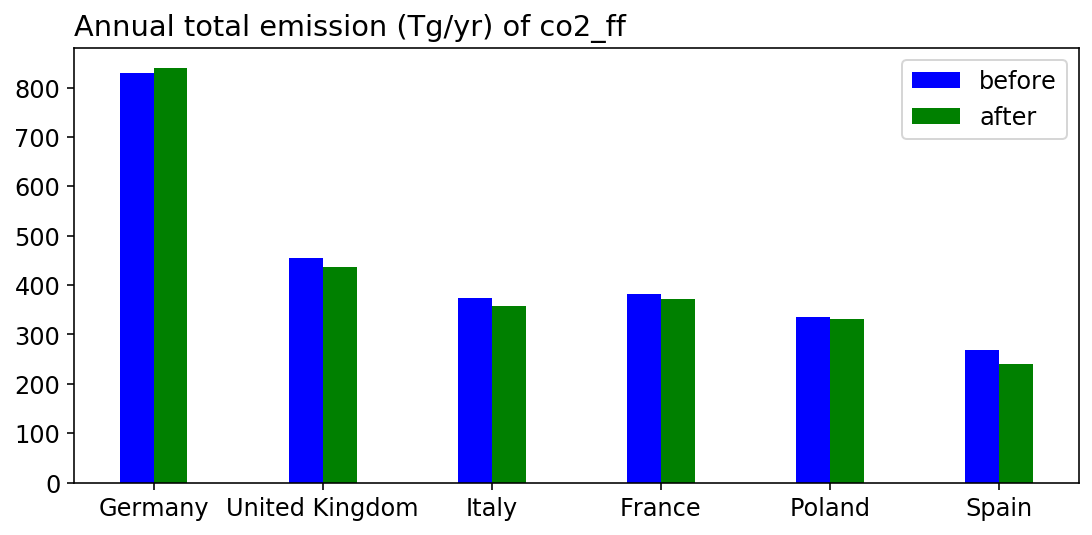

In [34]:
%%time

countries = ['Germany', 'United Kingdom', 'Italy', 'France', 'Poland', 'Spain']
var    = 'co2_ff'
before = country_totals(ds[var], countries)
after  = country_totals(regrid_ds[var], countries)

bar_pos = np.arange(len(countries)) + 1 # position of the bars
fig = plt.figure(figsize=[9, 4])
width = 0.2
bars_before = plt.bar(bar_pos-0.1, before*1e-9, width=width, color = 'b', label='before')
bars_after  = plt.bar(bar_pos+0.1, after*1e-9, width=width, color = 'g', label='after')
plt.xticks(bar_pos, countries)
plt.title('Annual total emission (Tg/yr) of ' + var, loc='left')
plt.legend()

In [36]:
# convert to flux kg/m2/s
ds_flux = unit_convert(regrid_ds , varnames, res_lat, res_lon)
ds_flux.attrs['comment'] = 'regridded by m.sadiq, May 2020'
ds_flux.to_netcdf(fdir + 'TNO_' + str(year) + '_0.25x0.3125.nc')

(36, 64)

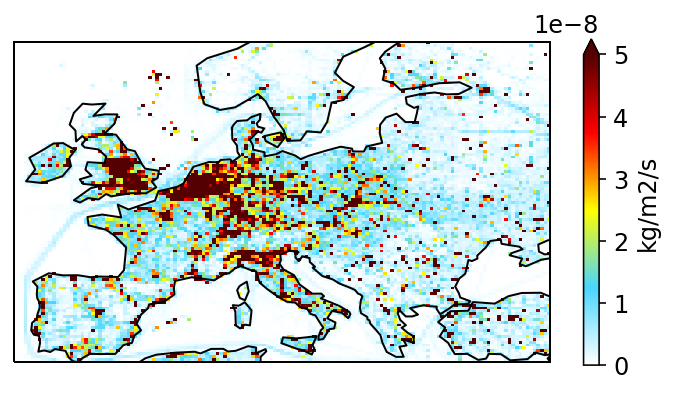

In [37]:
# testings:
# after regridding
fig = plt.figure(figsize=[6, 6])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
ax.coastlines()
ds_flux['co2_ff'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax = 5e-8, cmap=WhGrYlRd, cbar_kwargs={'shrink': 0.5, 'label': 'kg/m2/s'})
ax.set_xlim(-11,36)
ax.set_ylim(36,64)
